#  Librairies 

In [101]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics.pairwise import pairwise_distances
import networkx as nx
import itertools
from networkx.drawing.nx_agraph import graphviz_layout
from __future__ import division 
import collections
from networkx.algorithms.richclub import rich_club_coefficient 
from operator import itemgetter
from community import community_louvain
from networkx.algorithms import community
from itertools import count
import community
from networkx.drawing.nx_pydot import write_dot
from IPython.display import Image

# Exemple jouet

Afin de faciliter l'écriture des algorithmes et pour vérifier leur pertinence nous avons généré un jeu de données, pour le quel la recherche du nombre d'inversion est triviale. Cet exemple peut être résumé tel que : 
* Organisme A : (+)A  - (+)B - (+)C - (+)D - (+)E
* Organisme B : (-)D  - (-)C - (+)A - (+)B - (+)E  

Le signe (+) implique que la position du début du gène est inféfieure à celle de la fin du gène, et réciproquement pour le signe (-).

## Construction de la matrice

In [5]:
d_jouet = {'ID': ["A", "B", "C","D","E"], 'QAStart': [0, 2,4,6, 8],'QEnd': [1, 3,5,7,9] ,'SAStart': [4,6,3,1, 8], 'SEnd': [5, 7,2,0, 9] }
df_jouet=  pd.DataFrame(data=d_jouet)
df_jouet

,ID,QAStart,QEnd,SAStart,SEnd
0,A,0,1,4,5
1,B,2,3,6,7
2,C,4,5,3,2
3,D,6,7,1,0
4,E,8,9,8,9


## Recherche des arc

### Recherche des arcs pour l'organisme de référence (A)

In [6]:
def find_edges_orga_ref(S,E):
    """Cette fonction permet de chercher les arcs pour sur le chromosime de l'oganisme de référence. Chaque
    gène a deux voisins. Ainsi pour chaque gène, la fonction `find_edges_orga_ref` calcule la distance entre la fin 
    du gène courant et le début de tous les autres gènes. Le voisin du gène courant est finalement celui dont la
    distance est minimal. Sachant que nous chromosome circulaire le début du premier gène est nécessairement voisin
    de la fin du dernier, ceci constitue donc une arc."""
   
    # Initialisation
    l = [] # Liste des arcs
    max_l  = max(E)
    min_l = min(S)

    for i in range(len(E)): # Pour chaque position de fin 
        D = []  
        dist =[]
        for j in range(len(S)): # Pour chaque début
            if  E.index(E[i])!= S.index(S[j])  : # Si la position de début et de fin ne correspondent pas au même gène
                if E[i] != max_l and S[j] != min_l : # S'il ne s'agit d'une des extrémités sur un plan linéaire
                    d =abs( E[i]- S[j])  # Calcul de la distance 
                    D.append([d, E[i], S[j] , 'E' ,  'S' ])   # Mémorisation de la dstance et des indices
                    dist.append(d) 
        
                else : # S'il s'agit d'une des extrémité sur un plan linéaie
                    p1 = list(df_jouet["ID"][df_jouet["QEnd"]==max_l] )[0]
                    p1 = "E"+str(p1)
                    p2 = list(df_jouet["ID"][df_jouet['QAStart']==min_l] )[0]
                    p2 = "S"+str(p2)
                    if (p1, p2) not in l and (p2, p1) not in l: 
                        l.append((p1 ,p2) ) # Ajout de l'arc correspondante entre la min et max           
                    
            else : # Si l'indice i et j correspondent au même 
                D.append(['NA', 'NA', 'NA', "NA", 'NA']) # Ajour d'une liste "vide"
                dist.append('NA')
   
        minD_ID = D[dist.index(min(dist))]  # Calcul de la distance minimall 
        if 'NA' not in minD_ID : 
            p1 = list(df_jouet["ID"][df_jouet["QEnd"]==minD_ID[1]])[0]
            p2 = list(df_jouet["ID"][df_jouet["QAStart"]== minD_ID[2]])[0]
            if p1 != p2 :
                p1 = "E"+str(p1)
                p2 = "S"+str(p2)
                if  (p1, p2) not in l and (p2, p1) not in l:
                    l.append((p1 ,p2) ) # Ajout de l'arc corresponsdante  
    return l

#### Exemple :

In [7]:
EDGES1 = find_edges_orga_ref(list(df_jouet["QAStart"]), list(df_jouet["QEnd"]))
print(EDGES1)

[('EA', 'SB'), ('EE', 'SA'), ('EB', 'SC'), ('EC', 'SD'), ('ED', 'SE')]


#### Remarque :
Cette fonction aurait pu être simplifiée. En effet nous aurions pu trier la matrices des position pour l'orgnanisme 
de référence est associé chaque fin de gène au début du gène de la ligne suivante. La position de  début sur la première ligne 
aurait été associée à la position de fin sur la dernière ligne.

### Recherche des arcs pour l'organisme d'intérêt (B)

In [10]:
def find_edges(S,E):
    """Recherche des arcs dans l'organisme d'intérêt. Nous avons choisi de rechercher pour chaque extrémité (SStart_i ou SEnd_i)
    quel est son voisin le plus proche, par recherche de la distance minimale. Cette méthode nous permet d'obtenir une liste
    des arcs entre les extrémité (Start -> Start) ou (End -> End) ou (Start -> End). Aucun aucune arc ne relier les extrémités 
    d'un même gène. Le position miniamle est nécessairement reliée à la position maximale étant donné que nous étudions
    des génomes circulaires."""
    
    l = [] # Initialisation de la liste d'arcs
    t= S+E  # Ajout de toutes les positions Start et End 
    max_l  = max(t) # Recherche la "dernière extrémité"
    max_lID  = t.index(max_l) # Recupération de l'indice de la "denière" position
    
    min_l = min(t)  # Recherche la "première" extrémité
    min_lID  = t.index(min_l)# Recupération de l'indice de la "première" position
    
     # Attribution  d'un statut "Start=S" ou "End=E" à chaque position
    if max_lID < len(t)/2 :
        state_maxl = "S"
    else :
        state_maxl = "E"
    if min_lID < len(t)/2 :
        state_minl = "S"
    else :
        state_minl = "E"   
    T = []
    for i in range(len(t)):
        if i < len(t)/2 :
            T.append([t[i],'S'])
        else :
            T.append([t[i],'E'])
            
    for i in range(len(t)): # Pour chaque élément de t
        D = []  
        dist =[]
        for j in range(len(t)): # Pour chaque élément de t 
            if t.index(t[i]) + len(t)/2!= t.index(t[j]) and t.index(t[i])!= t.index(t[j]) : # Si les indices indices i et j ne se réfèrent pas au même gène
                if t[i] != max_l and t[i] != min_l and t[j] != max_l and t[j] != min_l : # S'il ne s'agit des extrémités 
                    d =abs( t[j]- t[i]) # Calcul de la distance
                    D.append([d, t[j], t[i] ,T[j][1] ,  T[i][1] ])  
                    dist.append(d)      
                else : # Si au moins l'un des indices se refère à une extrémité
                    # On relie la position min et max, et en conservant l'information début ou fin
                    if state_maxl =="E" and state_minl == "S" :
                        p1 = list(df_jouet["ID"][df_jouet["SEnd"]==max_l] )[0]
                        p1 = "E"+str(p1)
                        p2 = list(df_jouet["ID"][df_jouet['SAStart']==min_l] )[0]
                        p2 = "S"+str(p2)
                        if (p1, p2) not in l and (p2, p1) not in l:
                            l.append((p1 ,p2) )
                    elif state_maxl =="S" and state_minl == "E" :
                        p1 = list(df_jouet["ID"][df_jouet["SAStart"]==max_l] )[0]
                        p1 = "S"+str(p1)
                        p2 = list(df_jouet["ID"][df_jouet['SEnd']==min_l] )[0]
                        p2 = "E"+str(p2)
                        if (p1, p2) not in l and (p2, p1) not in l:
                            l.append((p1 ,p2) )
                            
                    elif state_maxl =="S" and state_minl == "S" :
                        p1 = list(df_jouet["ID"][df_jouet["SAStart"]==max_l] )[0]
                        p1 = "S"+str(P1)
                        p2 = list(df_jouet["ID"][df_jouet['SAStart']==min_l] )[0]
                        p2 = "S"+str(P2)
                        if  (p1, p2) not in l and (p2, p1) not in l:
                            l.append((p1 ,p2) )             
                    else :     
                        p1 = list(df_jouet["ID"][df_jouet["SEnd"]==max_l] )[0]
                        p1 = "E"+str(p1)
                        p2 = list(df_jouet["ID"][df_jouet['SEnd']==min_l] )[0]
                        p2 = "E"+str(p2)
                        if  (p1, p2) not in l and (p2, p1)not in l:
                            l.append((p1 ,p2) )
                      
            else : # Si les indices i et j se refèrent au même gène 
                D.append(['NA', 'NA', 'NA', "NA", 'NA']) # On ajoute un élément "vide"
                dist.append('NA')
   
        minD_ID = D[dist.index(min(dist))] # Recherche de la distance minimale
  
        # Ajout de l'arc se référant à la distance minimale en conservant l'information "début" ou "fin"
        if 'NA' not in minD_ID :            
            if  minD_ID[3] == 'E' and minD_ID[4] == 'S' :
                p1 = list(df_jouet["ID"][df_jouet["SEnd"]==minD_ID[1]])[0]
                p2 = list(df_jouet["ID"][df_jouet["SAStart"]== minD_ID[2]])[0]
                if p1 != p2 :
                    p1 = "E"+str(p1)
                    p2 = "S"+str(p2)
                    if  (p1, p2) not in l and (p2, p1) not in l:
                        l.append((p1 ,p2) )
            elif minD_ID[3] == 'S' and minD_ID[4] == 'E' :
                p1 = list(df_jouet["ID"][df_jouet["SAStart"]==minD_ID[1]])[0]
                p2 = list(df_jouet["ID"][df_jouet["SEnd"]== minD_ID[2]])[0]
                if p1 != p2 :
                    p1 = "S"+str(p1)
                    p2 = "E"+str(p2)
                    if  (p1, p2) not in l and (p2, p1) not in l:
                        l.append((p1 ,p2) )
            elif minD_ID[3] == 'S' and minD_ID[4] == 'S' :
                p1 = list(df_jouet["ID"][df_jouet["SAStart"]==minD_ID[1]])[0]
                p2 = list(df_jouet["ID"][df_jouet["SAStart"]== minD_ID[2]])[0]
                if p1 != p2 :
                    p1 = "S"+str(p1)
                    p2 = "S"+str(p2)
                    if  (p1, p2) not in l and (p2, p1) not in l:
                        l.append((p1 ,p2) )
            else :
                p1 = list(df_jouet["ID"][df_jouet["SEnd"]==minD_ID[1]])[0]
                p2 = list(df_jouet["ID"][df_jouet["SEnd"]== minD_ID[2]])[0]
                if p1 != p2 :
                    p1 = "E"+str(p1)
                    p2 = "E"+str(p2)
                    if  (p1, p2) not in l and (p2, p1) not in l:
                        l.append((p1 ,p2) )

        
    return l

#### Exemple

In [11]:
EDGES2 =find_edges(list(df_jouet["SAStart"]), list(df_jouet["SEnd"]) )
print(EDGES2)

[('EE', 'ED'), ('SC', 'SA'), ('EA', 'SB'), ('EC', 'SD'), ('EB', 'SE')]


#### Remarque :
Une démarche plus simple aurait pu être proposé en triant les éléments de la matrice des positions pour l'organisme d'intérêt.

###  Réprésentation du graph du  jeu de données  jouet 

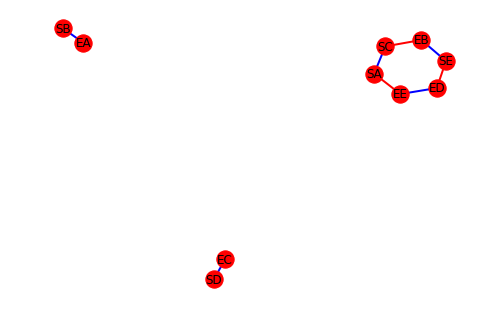

In [9]:
G=nx.Graph()

for i in EDGES1 :
    G.add_edge(i[0],i[1],color='r',weight=2)
    
for j in EDGES2 :
    G.add_edge(j[0],j[1],color='b',weight=2)

edges = G.edges()
colors = [G[u][v]['color'] for u,v in edges]
weights = [G[u][v]['weight'] for u,v in edges]

nx.draw(G,with_labels=True,  edges=edges, edge_color=colors, width=weights)


# Analyse du génome de Yersinia pestis CO92

## Importation des données générées sur R

In [17]:
data = pd.read_csv('data_V3.txt', sep="\t")

In [31]:
data.head()

,ID,QAStart,QEnd,SAStart,SEnd
1,1,1,168094,403127,571184
2,2,3347618,3518980,3774352,3945667
3,3,4237466,4385991,4502860,4651368
4,4,733701,863866,1147883,1278062
5,5,1108765,1237970,1504695,1633867


In [41]:
![title]('dot_matrix_v3.png')

/bin/sh: -c: line 0: syntax error near unexpected token `'dot_matrix_v3.png''
/bin/sh: -c: line 0: `[title]('dot_matrix_v3.png')'


## Recherche des arc

### Recherche des arcs pour l'organisme de référence 

In [23]:
def find_edges_orga_ref(S,E):
    """Cette fonction permet de chercher les arcs pour sur le chromosime de l'oganisme de référence. Chaque
    gène a deux voisins. Ainsi pour chaque gène, la fonction `find_edges_orga_ref` calcule la distance entre la fin 
    du gène courant et le début de tous les autres gènes. Le voisin du gène courant est finalement celui dont la
    distance est minimal. Sachant que nous chromosome circulaire le début du premier gène est nécessairement voisin
    de la fin du dernier, ceci constitue donc une arc."""
    
    l = []
    max_l  = max(E)
    min_l = min(S)

    for i in range(len(E)):
        D = []  
        dist =[]
        for j in range(len(S)):
            if  E.index(E[i])!= S.index(S[j])  :
                if E[i] != max_l and S[j] != min_l : 
                    d =abs( E[i]- S[j]) 
                    D.append([d, E[i], S[j] , 'E' ,  'S' ])  
                    dist.append(d) 
              
                else :
                    p1 = list(data["ID"][data["QEnd"]==max_l] )[0]
                    p1 = "E"+str(p1)
                    p2 = list(data["ID"][data['QAStart']==min_l] )[0]
                    p2 = "S"+str(p2)
                    if (p1, p2) not in l and (p2, p1) not in l:
                        l.append((p1 ,p2) )                      
            else :
                D.append(['NA', 'NA', 'NA', "NA", 'NA'])
                dist.append('NA')        
   
        minD_ID = D[dist.index(min(dist))]  
        if 'NA' not in minD_ID :
            p1 = list(data["ID"][data["QEnd"]==minD_ID[1]])[0]
            p2 = list(data["ID"][data["QAStart"]== minD_ID[2]])[0]
            if p1 != p2 :
                p1 = "E"+str(p1)
                p2 = "S"+str(p2)
                if  (p1, p2) not in l and (p2, p1) not in l:
                    l.append((p1 ,p2) )
        
    return l

####  Application

In [25]:
EDGES1 = find_edges_orga_ref(list(data["QAStart"]), list(data["QEnd"]))
print(EDGES1)

[('E1', 'S8'), ('E12', 'S1'), ('E2', 'S10'), ('E3', 'S12'), ('E4', 'S5'), ('E5', 'S4'), ('E6', 'S9'), ('E7', 'S11'), ('E8', 'S14'), ('E9', 'S2'), ('E10', 'S15'), ('E11', 'S7'), ('E13', 'S15'), ('E14', 'S4'), ('E15', 'S13')]


### Recherche des arcs pour l'organisme d'intérêt

In [27]:
def find_edges(S,E):
    """Recherche des arcs dans l'organisme d'intérêt. Nous avons choisi de rechercher pour chaque extrémité (SStart_i ou SEnd_i)
    quel est son voisin le plus proche, par recherche de la distance minimale. Cette méthode nous permet d'obtenir une liste
    des arcs entre les extrémité (Start -> Start) ou (End -> End) ou (Start -> End). Aucun aucune arc ne relier les extrémités 
    d'un même gène. Le position miniamle est nécessairement reliée à la position maximale étant donné que nous étudions
    des génomes circulaires."""
    
    l = []
    t= S+E
    max_l  = max(t)
    max_lID  = t.index(max_l)
    if max_lID < len(t)/2 :
        state_maxl = "S"
    else :
        state_maxl = "E"

    min_l = min(t)
   
    min_lID  = t.index(min_l)
    if min_lID < len(t)/2 :
        state_minl = "S"
    else :
        state_minl = "E"
        
    T = []
    for i in range(len(t)):
        if i < len(t)/2 :
            T.append([t[i],'S'])
        else :
            T.append([t[i],'E'])
            
   
    for i in range(len(t)):
        D = []  
        dist =[]
        for j in range(len(t)):
            if t.index(t[i]) + len(t)/2!= t.index(t[j]) and t.index(t[i])!= t.index(t[j])  :
                if t[i] != max_l and t[i] != min_l and t[j] != max_l and t[j] != min_l : 
                    d =abs( t[j]- t[i]) 
                    D.append([d, t[j], t[i] ,T[j][1] ,  T[i][1] ])  
                    dist.append(d) 
              
                else :
                   
                    if state_maxl =="E" and state_minl == "S" :
                        p1 = list(data["ID"][data["SEnd"]==max_l] )[0]
                        p1 = "E"+str(p1)
                        p2 = list(data["ID"][data['SAStart']==min_l] )[0]
                        p2 = "S"+str(p2)
                        if (p1, p2) not in l and (p2, p1) not in l:
                            l.append((p1 ,p2) )
                    elif state_maxl =="S" and state_minl == "E" :
                        p1 = list(data["ID"][data["SAStart"]==max_l] )[0]
                        p1 = "S"+str(p1)
                        p2 = list(data["ID"][data['SEnd']==min_l] )[0]
                        p2 = "E"+str(p2)
                        if (p1, p2) not in l and (p2, p1) not in l:
                            l.append((p1 ,p2) )
                    elif state_maxl =="S" and state_minl == "S" :
                        p1 = list(data["ID"][data["SAStart"]==max_l] )[0]
                        p1 = "S"+str(P1)
                        p2 = list(data["ID"][data['SAStart']==min_l] )[0]
                        p2 = "S"+str(P2)
                        if  (p1, p2) not in l and (p2, p1) not in l:
                            l.append((p1 ,p2) )
                    else :
                        p1 = list(data["ID"][data["SEnd"]==max_l] )[0]
                        p1 = "E"+str(p1)
                        p2 = list(data["ID"][data['SEnd']==min_l] )[0]
                        p2 = "E"+str(p2)
                        if  (p1, p2) not in l and (p2, p1)not in l:
                            l.append((p1 ,p2) )
                    
            else :
                D.append(['NA', 'NA', 'NA', "NA", 'NA'])
                dist.append('NA')
   
        minD_ID = D[dist.index(min(dist))]
        if 'NA' not in minD_ID :   
            if  minD_ID[3] == 'E' and minD_ID[4] == 'S' :
                p1 = list(data["ID"][data["SEnd"]==minD_ID[1]])[0]
                p2 = list(data["ID"][data["SAStart"]== minD_ID[2]])[0]
                if p1 != p2 :
                    p1 = "E"+str(p1)
                    p2 = "S"+str(p2)
                    if  (p1, p2) not in l and (p2, p1) not in l:
                        l.append((p1 ,p2) )
            elif minD_ID[3] == 'S' and minD_ID[4] == 'E' :
                p1 = list(data["ID"][data["SAStart"]==minD_ID[1]])[0]
                p2 = list(data["ID"][data["SEnd"]== minD_ID[2]])[0]
                if p1 != p2 :
                    p1 = "S"+str(p1)
                    p2 = "E"+str(p2)
                    if  (p1, p2) not in l and (p2, p1) not in l:
                        l.append((p1 ,p2) )
            elif minD_ID[3] == 'S' and minD_ID[4] == 'S' :
                p1 = list(data["ID"][data["SAStart"]==minD_ID[1]])[0]
                p2 = list(data["ID"][data["SAStart"]== minD_ID[2]])[0]
                if p1 != p2 :
                    p1 = "S"+str(p1)
                    p2 = "S"+str(p2)
                    if  (p1, p2) not in l and (p2, p1) not in l:
                        l.append((p1 ,p2) )
            else :
                p1 = list(data["ID"][data["SEnd"]==minD_ID[1]])[0]
                p2 = list(data["ID"][data["SEnd"]== minD_ID[2]])[0]
                if p1 != p2 :
                    p1 = "E"+str(p1)
                    p2 = "E"+str(p2)
                    if  (p1, p2) not in l and (p2, p1) not in l:
                        l.append((p1 ,p2) )


        
    return l

#### Application

In [29]:
EDGES2 = find_edges(list(data["SAStart"]), list(data["SEnd"]))
print(EDGES2)

[('E3', 'S15'), ('S8', 'S1'), ('E9', 'S2'), ('E10', 'S3'), ('E13', 'S4'), ('S14', 'S5'), ('S9', 'S6'), ('S11', 'S7'), ('E1', 'S8'), ('S2', 'S9'), ('S12', 'S10'), ('E7', 'S11'), ('E2', 'S12'), ('E4', 'S13'), ('E5', 'S14'), ('E12', 'E2'), ('S1', 'E15')]


###  Réprésentation du graph 

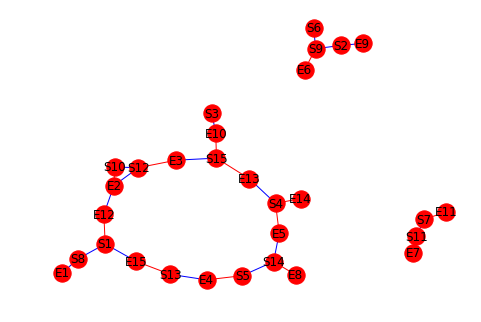

In [92]:
G=nx.Graph()

for i in EDGES1 :
    G.add_edge(i[0],i[1],color='r', length = 10)
    
for j in EDGES2 :
    G.add_edge(j[0],j[1],color='b', length = 10)

edges = G.edges()
colors = [G[u][v]['color'] for u,v in edges]
weights = [G[u][v]['length'] for u,v in edges]

pos = nx.spring_layout(G)
nx.draw(G, pos, edge_color=colors, weigths=weights, with_labels=True)

